# Fluxo de Projeto Machine Learning

## Objetivos

- Compreender as etapas de um projeto ML
- Aplicar boas práticas em cada fase
- Conhecer aspectos éticos em dados

## Pré-requisitos

- Lição anterior: Introdução ao ML


In [7]:
# Importações necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Configurar seeds para reprodutibilidade
np.random.seed(42)

# Configurar estilo dos gráficos
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (10, 6)

## 1. Etapas de um Projeto ML

### Fluxo típico:

1. **Definição do problema**
2. **Coleta e exploração de dados**
3. **Preparação dos dados**
4. **Seleção e treinamento do modelo**
5. **Avaliação do modelo**
6. **Deploy e monitoramento**

Vamos ver cada etapa com um exemplo prático:


## 2. Exemplo Prático: Previsão de Preços de Casas

### Etapa 1: Definição do Problema

- **Objetivo**: Prever preços de casas
- **Tipo**: Regressão (valor contínuo)
- **Métrica**: RMSE (Root Mean Squared Error)
- **Stakeholders**: Imobiliária, compradores


### Etapa 2: Coleta e Exploração de Dados


In [8]:
# Carregar dataset sintético (baseado no conceito do Boston Housing)
# Vamos criar dados sintéticos para evitar problemas éticos do dataset original
np.random.seed(42)

n_samples = 500
data = {
    "rooms": np.random.normal(6, 1, n_samples),  # número de quartos
    "age": np.random.uniform(0, 100, n_samples),  # idade da casa
    "distance": np.random.exponential(3, n_samples),  # distância do centro
    "tax_rate": np.random.uniform(300, 700, n_samples),  # taxa de impostos
    "education": np.random.uniform(10, 20, n_samples),  # índice educacional
}

# Criar target com relação com features
price = (
    data["rooms"] * 8
    + (100 - data["age"]) * 0.3
    + -data["distance"] * 2
    + -data["tax_rate"] * 0.02
    + data["education"] * 1.5
    + np.random.normal(0, 5, n_samples)  # ruído
)

# Garantir preços positivos
price = np.maximum(price, 10)

# Criar DataFrame
df = pd.DataFrame(data)
df["price"] = price

print("Dataset carregado com sucesso!")
print(f"Shape: {df.shape}")
df.head()

Dataset carregado com sucesso!
Shape: (500, 6)


,rooms,age,distance,tax_rate,education,price
0,6.496714,64.591724,6.163510,458.792607,14.503510,65.959624
1,5.861736,57.077830,0.089051,478.881016,17.488263,70.553045
2,6.647689,35.609673,5.242942,540.237733,16.511476,81.170740
3,7.523030,98.651525,0.413892,506.271771,16.209286,73.570670
4,5.765847,60.577482,1.224441,667.756789,13.523749,65.787538


In [9]:
# Análise exploratória
print("=== Informações Gerais ===")
print(df.info())
print("\n=== Estatísticas Descritivas ===")
print(df.describe())

=== Informações Gerais ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rooms      500 non-null    float64
 1   age        500 non-null    float64
 2   distance   500 non-null    float64
 3   tax_rate   500 non-null    float64
 4   education  500 non-null    float64
 5   price      500 non-null    float64
dtypes: float64(6)
memory usage: 23.6 KB
None

=== Estatísticas Descritivas ===
            rooms         age    distance    tax_rate   education       price
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000
mean     6.006838   50.095023    3.029632  500.763786   14.984685   69.528799
std      0.981253   29.087240    3.098790  115.965931    2.876043   14.531457
min      2.758733    0.463202    0.014857  301.287305   10.001347   23.186002
25%      5.299693   23.632203    0.812967  398.123805   12.782735   60.559013
5

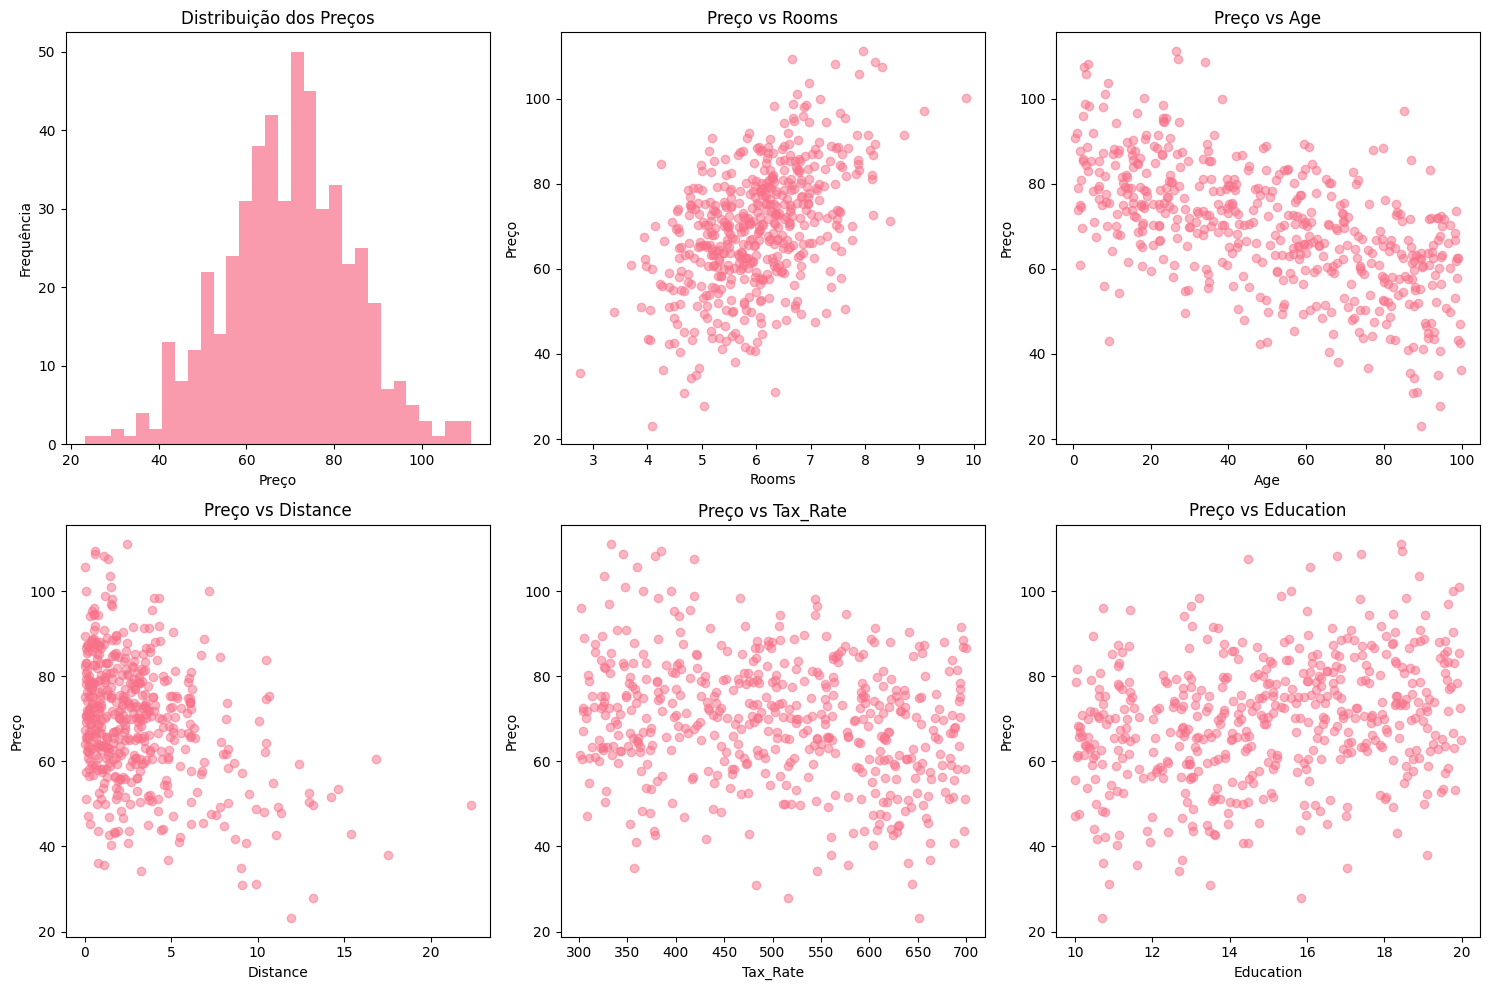

In [10]:
# Visualizações exploratórias
plt.figure(figsize=(15, 10))

# Distribuição do target
plt.subplot(2, 3, 1)
plt.hist(df["price"], bins=30, alpha=0.7)
plt.xlabel("Preço")
plt.ylabel("Frequência")
plt.title("Distribuição dos Preços")

# Correlação entre features e target
features = ["rooms", "age", "distance", "tax_rate", "education"]
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 2)
    plt.scatter(df[feature], df["price"], alpha=0.5)
    plt.xlabel(feature.title())
    plt.ylabel("Preço")
    plt.title(f"Preço vs {feature.title()}")

plt.tight_layout()
plt.show()

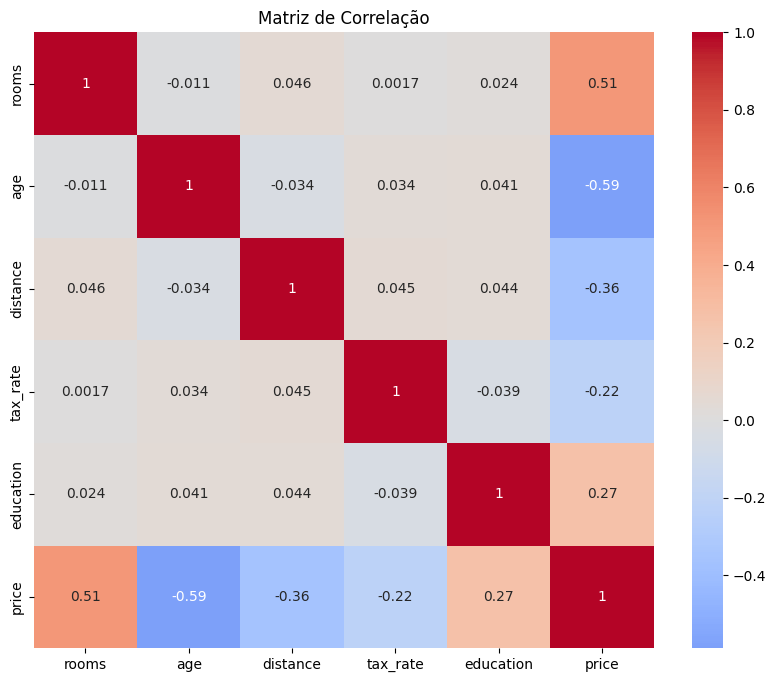

In [11]:
# Matriz de correlação
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de Correlação")
plt.show()

### Etapa 3: Preparação dos Dados


In [12]:
# Verificar valores ausentes
print("Valores ausentes por coluna:")
print(df.isnull().sum())

# Verificar outliers
print("\nOutliers detectados (usando IQR):")
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")

Valores ausentes por coluna:
rooms        0
age          0
distance     0
tax_rate     0
education    0
price        0
dtype: int64

Outliers detectados (usando IQR):
rooms: 4 outliers
age: 0 outliers
distance: 30 outliers
tax_rate: 0 outliers
education: 0 outliers
price: 9 outliers


In [13]:
# Separar features e target
X = df.drop("price", axis=1)
y = df["price"]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")

Dados de treino: (400, 5)
Dados de teste: (100, 5)


In [14]:
# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter de volta para DataFrame para manter nomes das colunas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Dados normalizados com sucesso!")
print("\nMédias após normalização (devem ser ~0):")
print(X_train_scaled.mean())
print("\nDesvios padrão após normalização (devem ser ~1):")
print(X_train_scaled.std())

Dados normalizados com sucesso!

Médias após normalização (devem ser ~0):
rooms        1.387779e-16
age          7.216450e-17
distance    -1.332268e-17
tax_rate    -2.220446e-16
education    5.329071e-17
dtype: float64

Desvios padrão após normalização (devem ser ~1):
rooms        1.001252
age          1.001252
distance     1.001252
tax_rate     1.001252
education    1.001252
dtype: float64


### Etapa 4: Seleção e Treinamento do Modelo


In [15]:
# Treinar modelo de regressão linear
model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("Modelo treinado com sucesso!")
print(f"\nCoeficientes do modelo:")
for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef:.3f}")
print(f"Intercept: {model.intercept_:.3f}")

Modelo treinado com sucesso!

Coeficientes do modelo:
rooms: 7.561
age: -8.662
distance: -6.259
tax_rate: -2.466
education: 4.380
Intercept: 69.302


### Etapa 5: Avaliação do Modelo


In [16]:
# Fazer previsões
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calcular métricas
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=== Métricas de Avaliação ===")
print(f"RMSE Treino: {train_rmse:.3f}")
print(f"RMSE Teste: {test_rmse:.3f}")
print(f"R² Treino: {train_r2:.3f}")
print(f"R² Teste: {test_r2:.3f}")

# Verificar overfitting
if abs(train_rmse - test_rmse) > train_rmse * 0.1:
    print("\n⚠️ Possível overfitting detectado!")
else:
    print("\n✅ Modelo parece bem generalizado.")

=== Métricas de Avaliação ===
RMSE Treino: 5.006
RMSE Teste: 4.446
R² Treino: 0.884
R² Teste: 0.896

⚠️ Possível overfitting detectado!


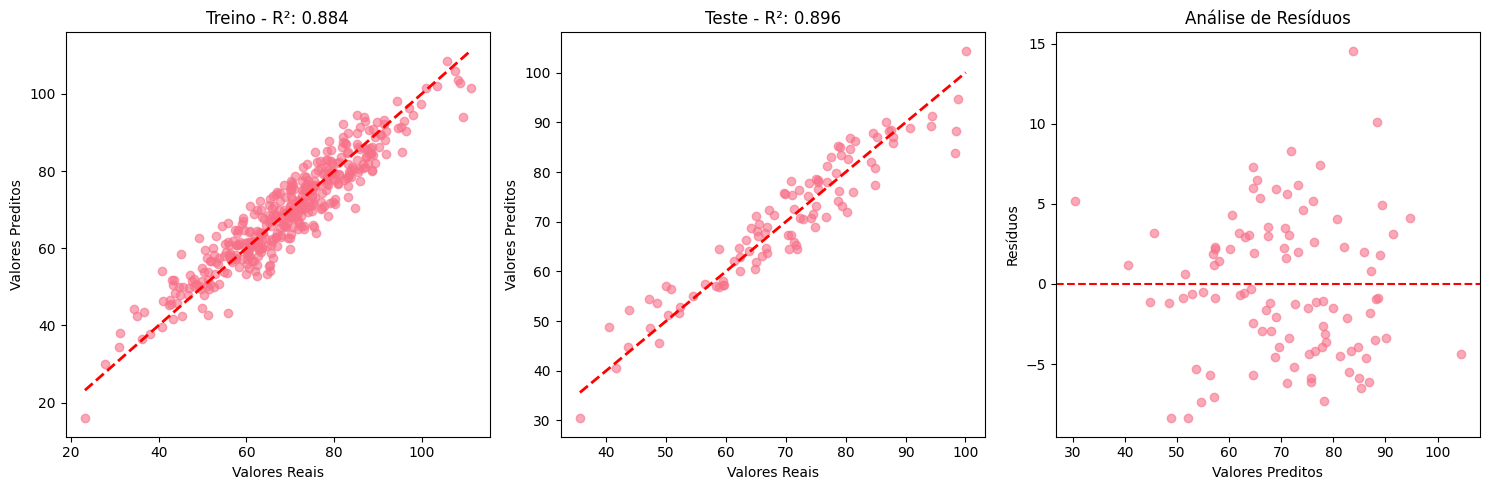

In [17]:
# Visualizar resultados
plt.figure(figsize=(15, 5))

# Predito vs Real - Treino
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title(f"Treino - R²: {train_r2:.3f}")

# Predito vs Real - Teste
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title(f"Teste - R²: {test_r2:.3f}")

# Resíduos
plt.subplot(1, 3, 3)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.title("Análise de Resíduos")

plt.tight_layout()
plt.show()

## 3. Ética em Dados e ML

### Princípios importantes:

1. **Privacidade**: Proteger dados pessoais
2. **Transparência**: Explicar como o modelo funciona
3. **Fairness**: Evitar discriminação e viés
4. **Responsabilidade**: Assumir responsabilidade pelos resultados
5. **Consentimento**: Obter permissão para uso dos dados

### Exemplos de problemas éticos:

- Algoritmos de contratação que discriminam por gênero
- Sistemas de reconhecimento facial com viés racial
- Uso de dados sem consentimento
- Falta de transparência em decisões automatizadas


## 4. Boas Práticas

### Durante o projeto:

- **Documentar** todas as decisões e experimentos
- **Versionar** código e dados
- **Validar** resultados com especialistas do domínio
- **Testar** o modelo em dados nunca vistos
- **Monitorar** performance em produção

### Checklist de qualidade:

- ✅ Problema bem definido
- ✅ Dados explorados e limpos
- ✅ Modelo avaliado adequadamente
- ✅ Métricas apropriadas para o problema
- ✅ Considerações éticas avaliadas
- ✅ Código reprodutível


## 5. Mini-Quiz

**Pergunta 1:** Qual é a primeira etapa de um projeto ML?

- a) Coleta de dados
- b) Definição do problema
- c) Treinamento do modelo

**Pergunta 2:** Por que dividimos os dados em treino e teste?

- a) Para acelerar o treinamento
- b) Para economizar memória
- c) Para avaliar a capacidade de generalização

**Pergunta 3:** O que indica um possível overfitting?

- a) Alta performance em treino e teste
- b) Baixa performance em treino e teste
- c) Alta performance em treino, baixa em teste


## Respostas do Quiz

1. **b) Definição do problema** - Precisamos saber o que queremos resolver
2. **c) Para avaliar a capacidade de generalização** - Teste simula dados nunca vistos
3. **c) Alta performance em treino, baixa em teste** - Modelo decorou os dados de treino


## Próximos Passos

02-regressão
